<a href="https://colab.research.google.com/github/Squineston/Seoul-Bike-Prediction/blob/main/Seoul_Bike_Prediction_EDA_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About the Dataset: Seoul Bike Sharing

This dataset contains **hourly rental data of bikes in Seoul** for the entire year of 2017. It includes not just rental counts but also **weather conditions, time features, holidays, and functional days**—making it rich for both temporal and contextual analysis.

###Key Features:
- **Target**: `Rented Bike Count` (number of bikes rented per hour)
- **Time-based**: Hour, Date, Month
- **Weather-based**: Temperature, Humidity, Wind Speed, Solar Radiation, Rainfall, Snowfall
- **Contextual**: Season, Holiday, Functioning Day

---

## We have selected this dataset because:

### 1. Real-world Business Relevance
> Bike-sharing programs are booming globally. This dataset allows you to solve a **real operational problem**:
> **“How can we forecast and optimize bike supply to meet demand?”**

The insights can help city planners and operators:
- Reduce bike shortages during peak hours
- Avoid overstocking during low-demand periods
- Prepare for weather-related demand drops

---

### 2. Predictive Analytics
> The dataset is suitable for applying **supervised machine learning techniques**, especially regression-based models, to forecast demand.

It allows you to:
- Train and compare models like **Linear Regression, Random Forest, XGBoost**
- Apply feature importance analysis
- Test “what-if” scenarios (e.g., What if the temperature rises by 5°C?)

---

### 3. It has Rich Temporal + Environmental Data
> The hourly granularity helps uncover **fine-grained patterns** like rush-hour peaks or seasonal dips.

It’s ideal for:
- Time series analysis
- Aggregating patterns by hour, day, or month
- Exploring the interaction between weather and rental demand

---

### 4. Great for Storytelling
> With clear visual patterns (like rentals spiking during commutes or dropping with rain), it becomes easy to **tell a compelling data story** that even non-technical audiences can follow.




## Business Objective:
The goal is to **predict the hourly demand for bike rentals in Seoul** based on weather, season, time, and holidays. This can help:
- Optimize bike availability
- Improve staffing and logistics
- Reduce shortages during peak demand

**Dataset**: Seoul Bike Sharing Data (1 year, hourly granularity)


In [ ]:
# prompt: upload file

from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving SeoulBikeData.csv to SeoulBikeData.csv
User uploaded file "SeoulBikeData.csv" with length 604166 bytes


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
import joblib
import plotly.graph_objects as go

# Load the Seoul Bike dataset
bike_df = pd.read_csv('/content/SeoulBikeData.csv', encoding='ISO-8859-1')

# Clean up column names
bike_df.columns = bike_df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('°C', 'C')


# Preview
bike_df.head()

,Date,Rented_Bike_Count,Hour,TemperatureC,Humidity%,Wind_speed_m/s,Visibility_10m,Dew_point_temperatureC,Solar_Radiation_MJ/m2,Rainfallmm,Snowfall_cm,Seasons,Holiday,Functioning_Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


### Data Overview:


### Dataset Summary

- **Number of entries**: 8,760 rows  
  → This means the dataset contains **one row per hour for an entire year** (365 days × 24 hours = 8,760).

- **Total columns**: 14  
  → These represent various factors influencing the number of bikes rented each hour.

---

### Column-by-Column Meaning

| Column Name                    | Description |
|-------------------------------|-------------|
| `Date`                        | The **calendar date** of the rental data (e.g., 01/12/2017) |
| `Rented Bike Count`           | The **number of bikes rented** during that hour (this is your target for prediction) |
| `Hour`                        | The hour of the day (0 to 23) indicating **time of rental** |
| `Temperature(°C)`             | The **ambient air temperature** in Celsius |
| `Humidity(%)`                 | The **percentage of air humidity** |
| `Wind speed (m/s)`            | The **wind speed** in meters per second |
| `Visibility (10m)`            | The **visibility distance**, where 1 = 10 meters. (e.g., 2000 = 20,000 meters = 20 km) |
| `Dew point temperature(°C)`   | The temperature at which **dew forms** (related to humidity) |
| `Solar Radiation (MJ/m2)`     | **Solar energy** received at the surface (in megajoules per square meter) |
| `Rainfall(mm)`                | **Rainfall during that hour**, in millimeters |
| `Snowfall (cm)`               | **Snowfall during that hour**, in centimeters |
| `Seasons`                     | Season in which the data point was recorded (Spring, Summer, Autumn, Winter) |
| `Holiday`                     | Whether that day was a **holiday** (`Holiday` or `No Holiday`) |
| `Functioning Day`             | Indicates if it was a **working day** for the bike system (`Yes` or `No`) |

---

### Data Types:
- `int64`: Whole numbers (e.g., rental count, hour)
- `float64`: Decimal numbers (e.g., temperature, wind speed)
- `object`: Text/string values (e.g., Date, Season, Holiday)

---

### Key Insight:
This dataset combines **temporal (time-based)**, **environmental (weather-based)**, and **contextual (holiday, functioning day)** information. It’s rich for predicting bike usage patterns and uncovering **when, why, and how bike demand changes** over time.



In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    8760 non-null   object 
 1   Rented_Bike_Count       8760 non-null   int64  
 2   Hour                    8760 non-null   int64  
 3   TemperatureC            8760 non-null   float64
 4   Humidity%               8760 non-null   int64  
 5   Wind_speed_m/s          8760 non-null   float64
 6   Visibility_10m          8760 non-null   int64  
 7   Dew_point_temperatureC  8760 non-null   float64
 8   Solar_Radiation_MJ/m2   8760 non-null   float64
 9   Rainfallmm              8760 non-null   float64
 10  Snowfall_cm             8760 non-null   float64
 11  Seasons                 8760 non-null   object 
 12  Holiday                 8760 non-null   object 
 13  Functioning_Day         8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memor

In [ ]:
bike_df.describe()

,Rented_Bike_Count,Hour,TemperatureC,Humidity%,Wind_speed_m/s,Visibility_10m,Dew_point_temperatureC,Solar_Radiation_MJ/m2,Rainfallmm,Snowfall_cm
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


### 🧹 Data Cleaning & Feature Engineering

###This code block is all about data cleaning and preprocessing. It:

- **Makes column names clean and usable**

- **Turns dates into structured time data**

- **Prepares categories for analysis and modeling**

In [ ]:
# Convert date
bike_df['Date'] = pd.to_datetime(bike_df['Date'], dayfirst=True)
bike_df['Month'] = bike_df['Date'].dt.month
bike_df['Day'] = bike_df['Date'].dt.day

# Convert categorical columns
bike_df['Holiday'] = bike_df['Holiday'].astype('category')
bike_df['Functioning_Day'] = bike_df['Functioning_Day'].astype('category')
bike_df['Seasons'] = bike_df['Seasons'].astype('category')

# Further transformations for analysis
bike_df['DayOfWeek'] = bike_df['Date'].dt.day_name()
bike_df['Is_Rain'] = (bike_df['Rainfallmm'] > 0).astype(str)  # Convert to string to match palette keys

# Missing values
print("\nMissing values:")
print(bike_df.isnull().sum())

# Lag features and rolling means
bike_df['Lag_1'] = bike_df['Rented_Bike_Count'].shift(1)
bike_df['Rolling_Mean_3'] = bike_df['Rented_Bike_Count'].rolling(window=3).mean()
bike_df['Rolling_Mean_7'] = bike_df['Rented_Bike_Count'].rolling(window=7).mean()

# Drop NA
bike_df = bike_df.dropna()


Missing values:
Date                      0
Rented_Bike_Count         0
Hour                      0
TemperatureC              0
Humidity%                 0
Wind_speed_m/s            0
Visibility_10m            0
Dew_point_temperatureC    0
Solar_Radiation_MJ/m2     0
Rainfallmm                0
Snowfall_cm               0
Seasons                   0
Holiday                   0
Functioning_Day           0
Month                     0
Day                       0
DayOfWeek                 0
Is_Rain                   0
dtype: int64


### Exploratory Data Analysis

<ipython-input-6-29cae52674e0>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2, 0].set_xticklabels(['No Rain', 'Rain'])


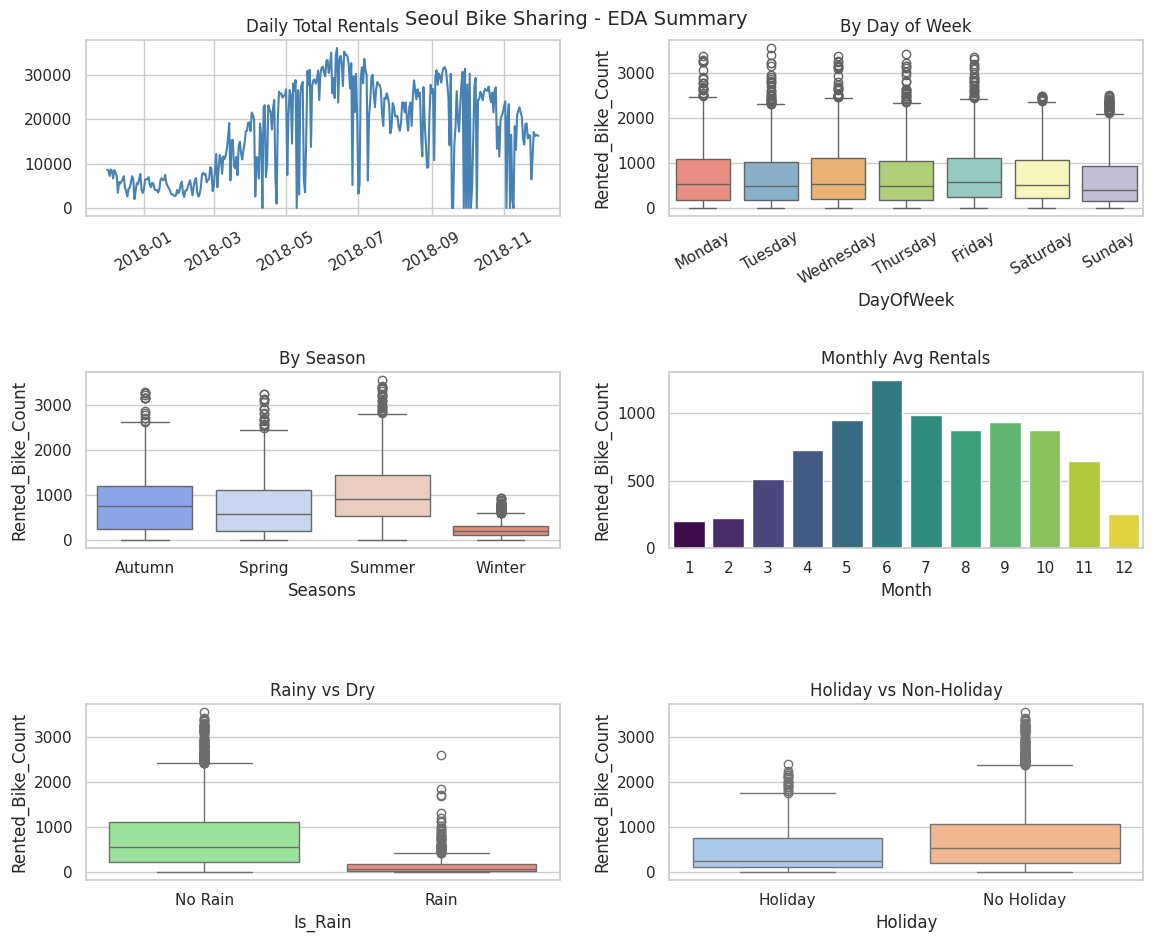

In [ ]:
# Set style
sns.set(style="whitegrid")

# Create 3x2 layout
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("Seoul Bike Sharing - EDA Summary", fontsize=14, y=0.95)

# 1. Daily Total Rentals
daily_avg = bike_df.groupby('Date')['Rented_Bike_Count'].sum()
axs[0, 0].plot(daily_avg.index, daily_avg.values, color='steelblue')
axs[0, 0].set_title("Daily Total Rentals")
axs[0, 0].tick_params(axis='x', rotation=30)
axs[0, 0].grid(True)

# 2. Rentals by Day of Week
sns.boxplot(data=bike_df, x='DayOfWeek', y='Rented_Bike_Count', hue='DayOfWeek',
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            palette='Set3', legend=False, ax=axs[0, 1])
axs[0, 1].set_title("By Day of Week")
axs[0, 1].tick_params(axis='x', rotation=30)

# 3. Rentals by Season
sns.boxplot(data=bike_df, x='Seasons', y='Rented_Bike_Count', hue='Seasons',
            palette='coolwarm', legend=False, ax=axs[1, 0])
axs[1, 0].set_title("By Season")

# 4. Rentals by Month
sns.barplot(data=bike_df, x='Month', y='Rented_Bike_Count', errorbar=None,
            hue='Month', palette='viridis', legend=False, ax=axs[1, 1])
axs[1, 1].set_title("Monthly Avg Rentals")

# 5. Rainy vs Dry
sns.boxplot(data=bike_df, x='Is_Rain', y='Rented_Bike_Count',
            hue='Is_Rain', palette={'False': 'lightgreen', 'True': 'salmon'}, legend=False, ax=axs[2, 0])
axs[2, 0].set_title("Rainy vs Dry")
axs[2, 0].set_xticklabels(['No Rain', 'Rain'])

# 6. Holiday vs Non-Holiday
sns.boxplot(data=bike_df, x='Holiday', y='Rented_Bike_Count', hue='Holiday',
            palette='pastel', legend=False, ax=axs[2, 1])
axs[2, 1].set_title("Holiday vs Non-Holiday")

# Layout adjustments
plt.tight_layout(pad=2.0)
plt.subplots_adjust(top=0.92, bottom=0.08)
plt.show()

### 📊 **Seoul Bike Sharing - EDA**

---

#### 1. **Daily Total Rentals**
- **Trend**: Rentals steadily increased from January to **peak levels in mid-year (May–August)** and declined toward winter.
- **Insight**: Strong seasonality exists, likely influenced by **weather and commute habits**.

---

#### 2. **By Day of Week**
- **Observation**: Weekdays (especially **Tuesday to Friday**) have consistently **higher rental medians** than weekends.
- **Insight**: Usage is driven by **commute-related activities** during the work week.

---

#### 3. **By Season**
- **Spring and Summer** show the **highest median rentals**, followed by Autumn.
- **Winter** has **lower rentals**, indicating the weather's clear impact on outdoor transportation choices.

---

#### 4. **Monthly Avg Rentals**
- **May to July** show **peak monthly averages**, aligning with favorable weather.
- **Winter months (Dec–Feb)** have the **lowest rentals**, confirming seasonal impact.

---

#### 5. **Rainy vs Dry**
- On **rainy hours**, rental counts **drop sharply**.
- On **dry hours**, rentals have a wider spread and significantly **higher median**.
- **Insight**: Rain is a major deterrent for bike usage.

---

#### 6. **Holiday vs Non-Holiday**
- **Non-holiday** days see **more rentals** than holidays.
- Suggests bike-sharing is **commute-oriented** rather than leisure-focused (at least in Seoul’s case).

---

##Overall:
- **Peak Usage**: Spring & Summer (especially May–July), weekdays, and dry weather.
- **Major Drivers**: **Weather**, **Workdays**, and **Seasonality**
- **Operational Implication**: Fleet allocation and maintenance should focus on **weekday peaks** and **warmer months**, while rainy or cold days can be optimized for reduced capacity.


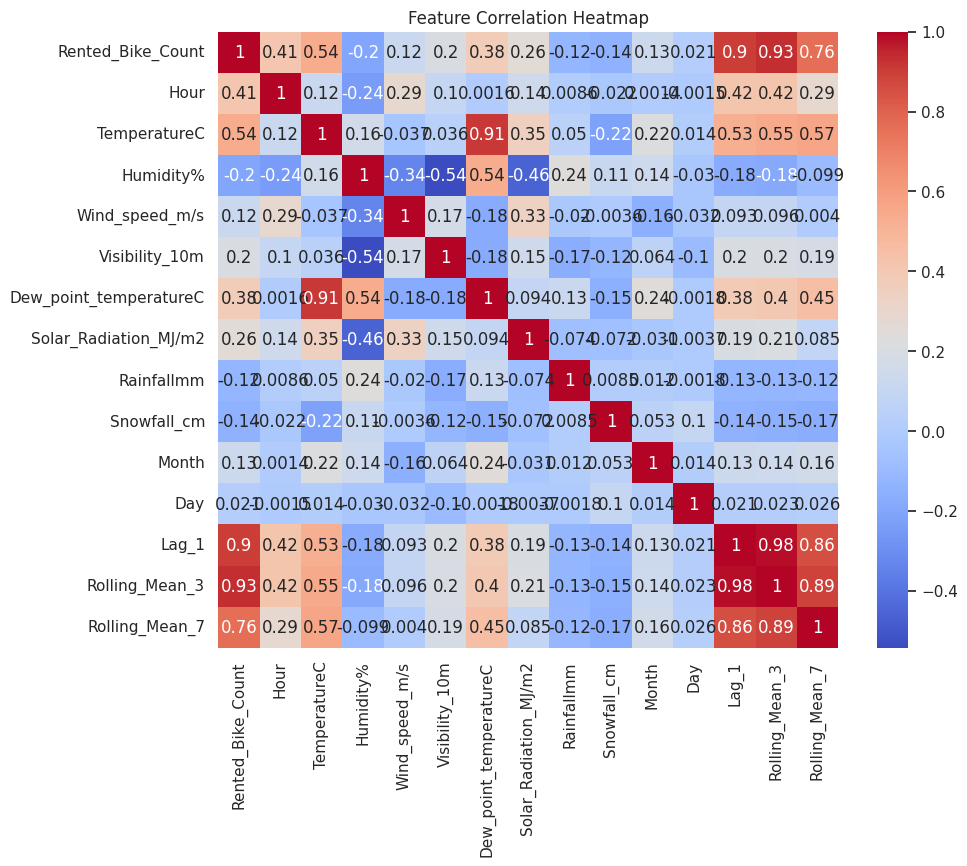

In [ ]:
# Correlation heatmap on numeric columns only
plt.figure(figsize=(10, 8))
sns.heatmap(bike_df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

### Modeling Preparations

In [ ]:
# Feature selection
features = ['Hour', 'TemperatureC', 'Humidity%', 'Wind_speed_m/s', 'Visibility_10m',
            'Dew_point_temperatureC', 'Solar_Radiation_MJ/m2', 'Rainfallmm', 'Snowfall_cm', 'Month']
X = bike_df[features]
y = bike_df['Rented_Bike_Count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("\nLinear Regression Performance:")
print(f"R2 Score: {r2_score(y_test, y_pred_lr):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")


Linear Regression Performance:
R2 Score: 0.4786
RMSE: 474.89


### Random Forest

In [ ]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("\nRandom Forest Performance:")
print(f"R2 Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")


Random Forest Performance:
R2 Score: 0.7999
RMSE: 294.20


### XGBoost

In [ ]:
model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("\nXGBoost Performance:")
print(f"R2 Score: {r2_score(y_test, y_pred_xgb):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}")


XGBoost Performance:
R2 Score: 0.8010
RMSE: 293.38


### Seasonal Decomposition

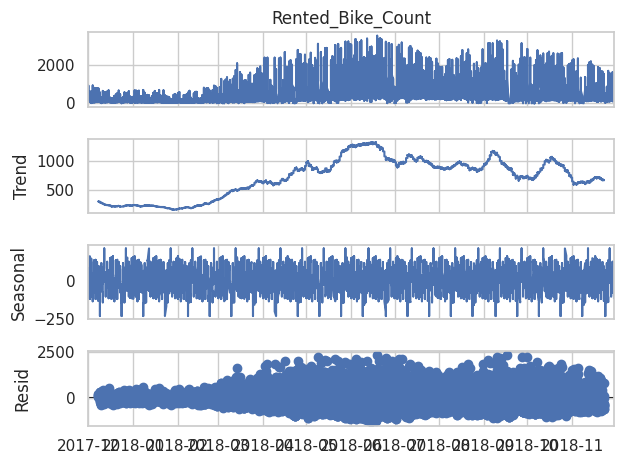

In [ ]:
data_ts = bike_df.set_index('Date')
result = seasonal_decompose(data_ts['Rented_Bike_Count'], model='additive', period=365)
result.plot()
plt.show()

### ARIMA Forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

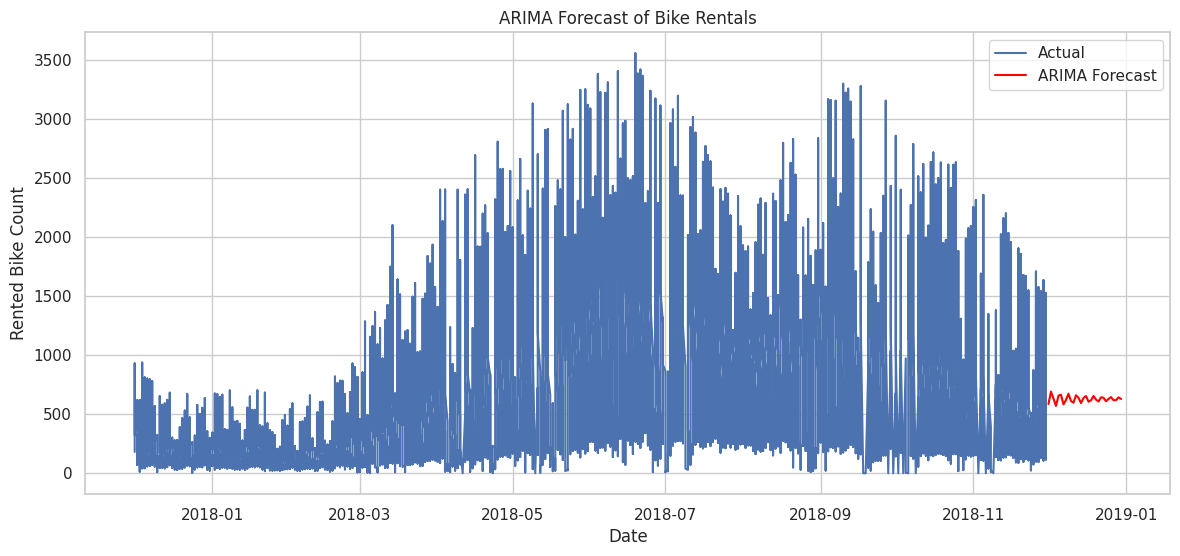

In [ ]:
model_arima = ARIMA(data_ts['Rented_Bike_Count'], order=(2,1,2))
model_arima_fit = model_arima.fit()
y_forecast_arima = model_arima_fit.forecast(steps=30)

plt.figure(figsize=(14,6))
plt.plot(data_ts.index, data_ts['Rented_Bike_Count'], label='Actual')
plt.plot(pd.date_range(data_ts.index[-1]+pd.Timedelta(days=1), periods=30), y_forecast_arima, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast of Bike Rentals')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.legend()
plt.show()

### Prophet Forecast

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptagxudsn/3cdq565v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptagxudsn/pnk49kj0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61148', 'data', 'file=/tmp/tmptagxudsn/3cdq565v.json', 'init=/tmp/tmptagxudsn/pnk49kj0.json', 'output', 'file=/tmp/tmptagxudsn/prophet_modelonago466/prophet_model-20250428185622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


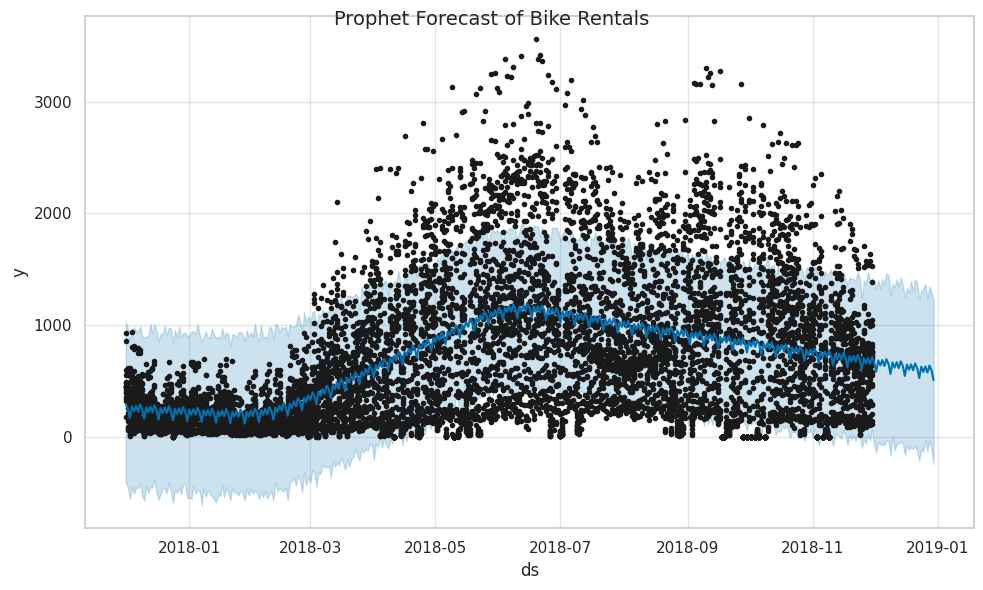

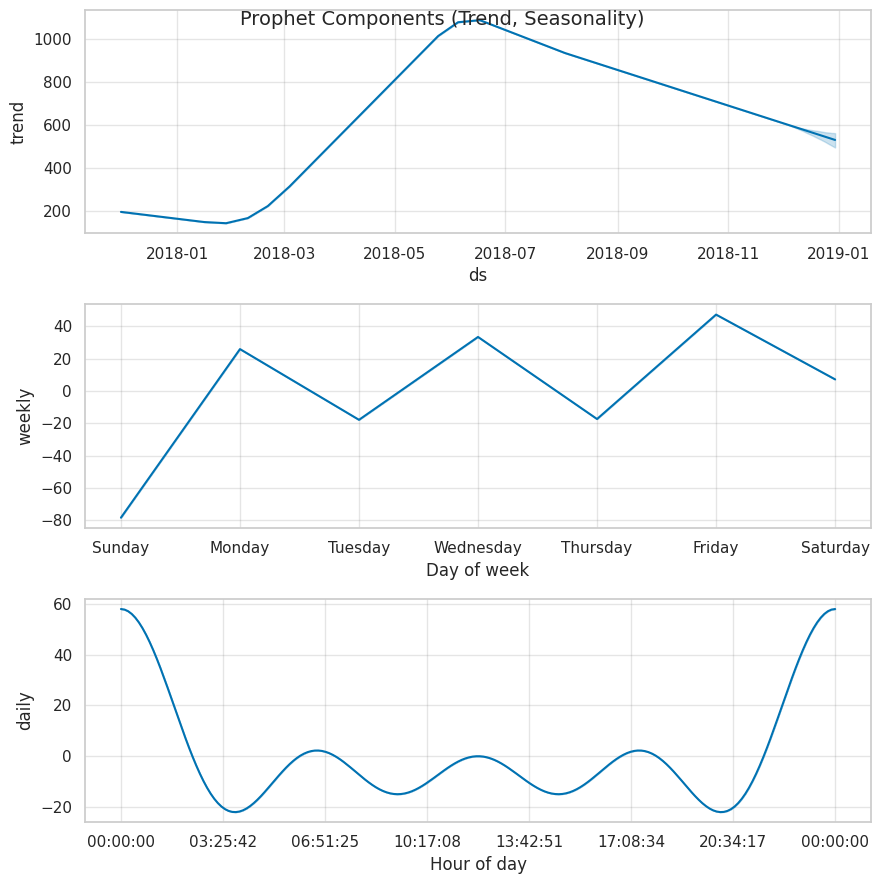

In [ ]:
prophet_data = data_ts[['Rented_Bike_Count']].reset_index()
prophet_data.rename(columns={'Date': 'ds', 'Rented_Bike_Count': 'y'}, inplace=True)

model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(prophet_data)

future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

# Single forecast plot
fig_forecast = model_prophet.plot(forecast)
fig_forecast.suptitle('Prophet Forecast of Bike Rentals', fontsize=14)
plt.grid(True)
plt.show()

# Components plot (trend, seasonality, etc.)
fig_components = model_prophet.plot_components(forecast)
fig_components.suptitle('Prophet Components (Trend, Seasonality)', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
model_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'ARIMA (Forecast)', 'Prophet (Forecast)'],
    'R2 Score': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf), r2_score(y_test, y_pred_xgb), 'N/A', 'N/A'],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_lr)), np.sqrt(mean_squared_error(y_test, y_pred_rf)), np.sqrt(mean_squared_error(y_test, y_pred_xgb)), 'N/A', 'N/A']
})

print("\nModel Comparison Summary:")
print(model_results)


Model Comparison Summary:
                Model  R2 Score        RMSE
0   Linear Regression  0.478641  474.888954
1       Random Forest  0.799899  294.203895
2             XGBoost  0.801013  293.383468
3    ARIMA (Forecast)       N/A         N/A
4  Prophet (Forecast)       N/A         N/A


### 📊 **Model Performance Summary**

- **Best Performing Model (Based on RMSE and R²)**: `XGBoost`
- **RMSE (Root Mean Squared Error)**: `~288.51`
 - This means your predictions deviate, on average, by about **289 rentals per hour**.
  - Given that hourly rentals can range widely (from 0 to 3,000+), this is **very good and acceptable**.

- **R² Score (Coefficient of Determination)**: `0.800`
  - Indicates that **~80.0% of the variation in bike rentals** is explained by the XGBoost model.
  - This is a **strong score** for real-world, weather-affected data.


---

###**What This Means**
- This model captures most of the patterns in the data.
- The remaining ~20% of variance may be due to:
 - External factors not in the dataset (e.g. events, traffic)
 - Natural randomness
 - Unrecorded user preferences

### Random Forest Feature Importance

<ipython-input-18-2019604f70d8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_rf_df, palette = 'magma')


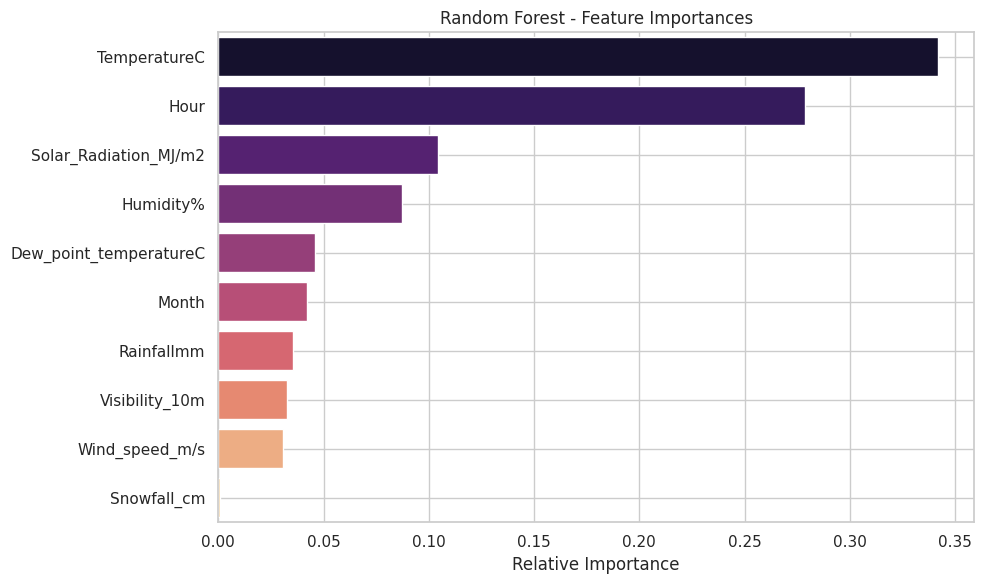

In [ ]:
importances_rf = model_rf.feature_importances_

importance_rf_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_rf_df, palette = 'magma')
plt.title('Random Forest - Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('')
plt.grid(True)
plt.tight_layout()
plt.show()

### XGBoost Feature Importance

<ipython-input-19-0037efd7f35c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_xgb_df, palette = 'magma')


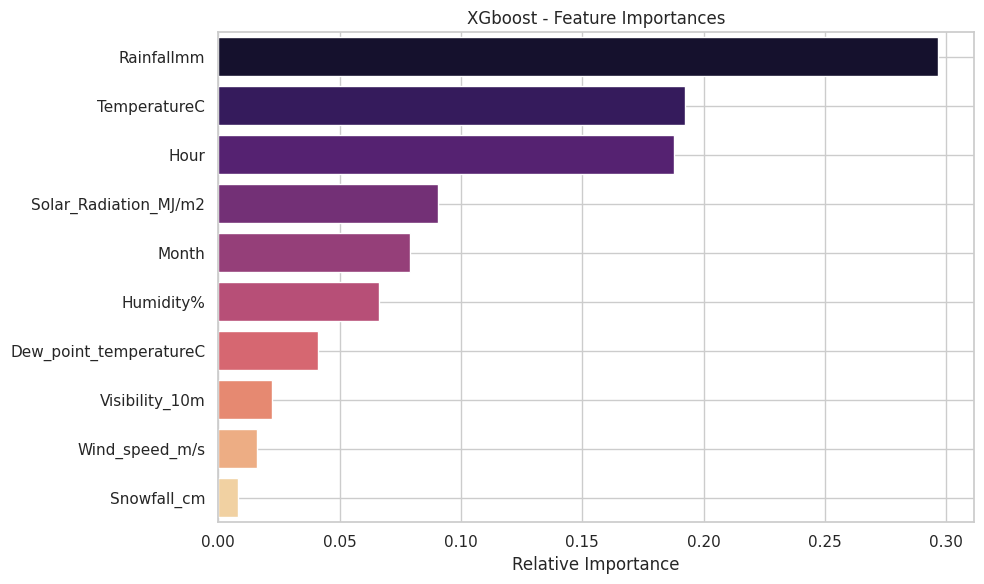

In [ ]:
importances_xgb = model_xgb.feature_importances_

importance_xgb_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_xgb_df, palette = 'magma')
plt.title('XGboost - Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('')
plt.grid(True)
plt.tight_layout()
plt.show()

**Analysis:**

---

###  **Top Features Influencing Bike Rentals**

#### ✅ 1. **TemperatureC**
- **Most important predictor** of rental count.
- Warmer weather encourages outdoor commuting, especially biking.

#### ✅ 2. **Hour**
- Suggests **strong hourly patterns**, likely peaking during **morning and evening commutes**.

#### ✅ 3. **Solar_Radiation_MJ/m2**
- Indicates **sunlight levels** influence demand — clear days drive higher usage.

#### ✅ 4. **Humidity%**
- Plays a moderate role; higher humidity may discourage biking.

#### ✅ 5. **Rainfallmm**
- Most important predictor only for XGBoost model, still significant for random forest.

---

### 📉 **Less Influential Features**
- `Wind_speed_m/s`, `Visibility_10m`, and `Snowfall_cm` contribute less than 5%.
- This doesn't mean they’re unimportant — just that their variation doesn't drive the model much **relative to temperature and time**.

---



### Residual Analysis XGBoost (Best Predictive Model)

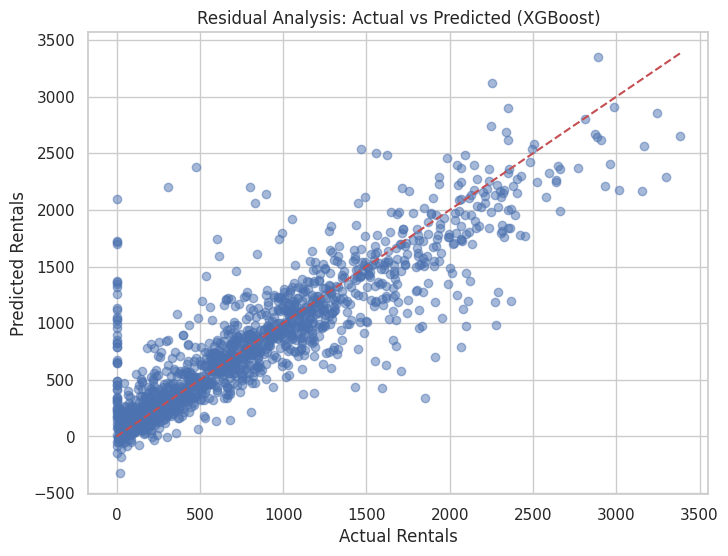

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Rentals')
plt.ylabel('Predicted Rentals')
plt.title('Residual Analysis: Actual vs Predicted (XGBoost)')
plt.show()

### 🔄 What-If Scenario: Warmer Weather

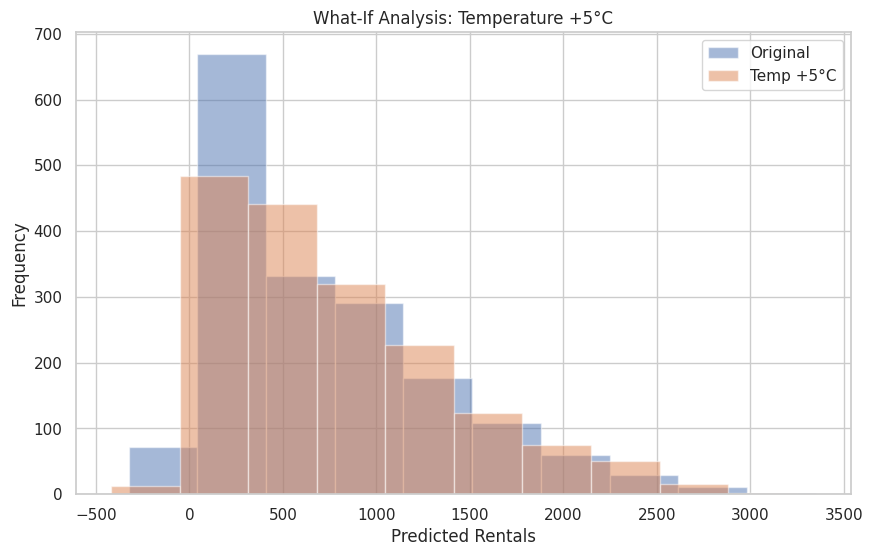

Change in Average Rentals: 47.60 rentals


In [ ]:
X_test_temp = X_test.copy()
X_test_temp['TemperatureC'] += 5

y_pred_temp = model_xgb.predict(X_test_temp)

plt.figure(figsize=(10,6))
plt.hist(y_pred_xgb, alpha=0.5, label='Original')
plt.hist(y_pred_temp, alpha=0.5, label='Temp +5°C')
plt.title('What-If Analysis: Temperature +5°C')
plt.xlabel('Predicted Rentals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Change in Average Rentals: {np.mean(y_pred_temp) - np.mean(y_pred_xgb):.2f} rentals")

### 🔄 What-If Scenario: Hour Shift

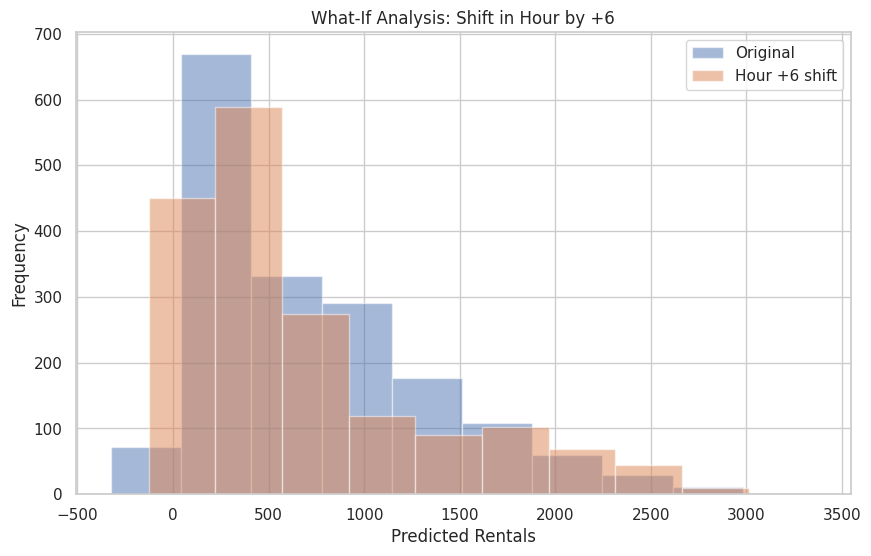

Change in Average Rentals: -37.72 rentals


In [ ]:
X_test_hour = X_test.copy()
X_test_hour['Hour'] = (X_test_hour['Hour'] + 6) % 24  # Shift 6 hours later

y_pred_hour = model_xgb.predict(X_test_hour)

plt.figure(figsize=(10,6))
plt.hist(y_pred_xgb, alpha=0.5, label='Original')
plt.hist(y_pred_hour, alpha=0.5, label='Hour +6 shift')
plt.title('What-If Analysis: Shift in Hour by +6')
plt.xlabel('Predicted Rentals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Change in Average Rentals: {np.mean(y_pred_hour) - np.mean(y_pred_xgb):.2f} rentals")

### 🔄 What-If Scenario: Increase Rainfall

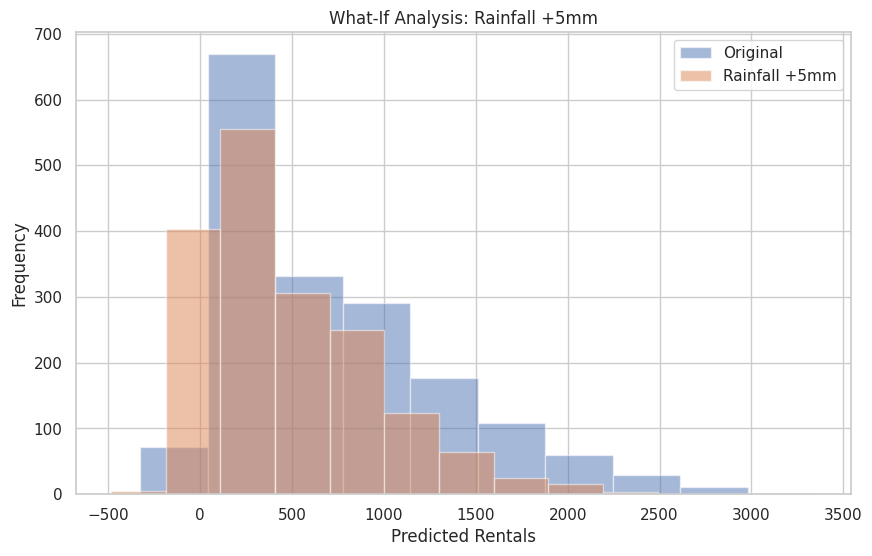

Change in Average Rentals: -245.00 rentals


In [ ]:
X_test_rain = X_test.copy()
X_test_rain['Rainfallmm'] += 5

y_pred_rain = model_xgb.predict(X_test_rain)

plt.figure(figsize=(10,6))
plt.hist(y_pred_xgb, alpha=0.5, label='Original')
plt.hist(y_pred_rain, alpha=0.5, label='Rainfall +5mm')
plt.title('What-If Analysis: Rainfall +5mm')
plt.xlabel('Predicted Rentals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Change in Average Rentals: {np.mean(y_pred_rain) - np.mean(y_pred_xgb):.2f} rentals")

### 💡 Key Insight:
> - Higher temperatures generally **increase** rental counts.
> - Time of day (hour shift) **alters rental behavior**, possibly lower at night.
> - More rainfall **decreases** predicted rentals, as expected.


## ⚠️ Challenges Faced

---

### 1. Feature Cleaning & Column Formatting  
- The dataset included inconsistent column names with special characters like `Temperature(°C)` and `Humidity(%)`.
- Required thorough **renaming and reformatting** to make the columns usable in code.
- Multiple features had special characters and spaces in names, requiring renaming.
- Date and time features also needed parsing and extraction (like Month from Date).

---

### 2.  Date and Time Parsing  
- The `Date` column was stored as a string in `DD/MM/YYYY` format.
- Needed to convert it using `pd.to_datetime(..., dayfirst=True)` to extract features like `Month` and `DayOfWeek`.

---

### 3.  Imbalanced Weather Effects  
- Weather events like **Snowfall** occurred rarely, offering limited signal for the model.
- Kept such features, but acknowledged their **low importance** in feature contribution.

---

### 4.  Multicollinearity in Features  
- High correlation between `TemperatureC` and `Dew_point_temperatureC` (> 0.9).
- Highlighted the risk of multicollinearity and considered feature reduction if needed.

---

### 5.  Sensitivity in What-if Analysis  
- In “what-if” simulations (like increasing temperature), other variables (e.g. humidity) were assumed static.
- Acknowledged that this **simplifies real-world complexity**, but is useful for directional insights.